# `Notebook Contents`
- Importing The Dependencies
- Collecting The Data
- Data Annotation
- Loading The Images
- Splitting The Data
- Data Augmentation
- Data Preparation
- Building The DL Models
- Real Time Face Tracking

### Importing The Dependencies

In [76]:
# Operating System
import os

# OpenCV
import cv2

# uuid
import uuid

# Time
import time

# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# Random
import random

# Data augmentation
import albumentations as alb

# Json
import json

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

### Collecting The Data

In [2]:
# Preparing the directories
# Make data dir
os.makedirs('Data')

# Make two dirs inside data dir
os.makedirs('Data/Images')
os.makedirs('Data/Labels')

# The images path
img_path = os.path.join('Data','Images')

In [5]:
# Capturing images
# Define my webcamera
cap = cv2.VideoCapture(0)

# Get 50 images
for i in range(50):
    # Collecting images msg
    print(f'Collecting image_{i + 1}')
    
    # Get the frame
    ret,frame = cap.read()
    
    # Save the frame
    cv2.imwrite(os.path.join(img_path,str(uuid.uuid1())+'.jpg'),frame)
    
    # Show the image
    cv2.imshow('Frame',frame)
    
    # Sleep
    time.sleep(0.8)
    
    # Close the window
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Releasing the capture
cap.release()

# Destroy all windows
cv2.destroyAllWindows()

### Data Annotation

In [8]:
# Apply annotation
!labelme

### Loading The Images

In [91]:
# Load images
def load_img(path):
    # Byte img
    byte_img = tf.io.read_file(path)
    
    # Decode it
    img = tf.io.decode_jpeg(byte_img)
    
    # Return the image
    return img

# Reading the images
images = tf.data.Dataset.list_files('Data/Images/*.jpg',shuffle = False)

# Get an image
images = images.map(load_img)

### Splitting The Data

In [171]:
# No.of training images = 84
# No.of testing images = 10
# No.of validation images = 11

#Creating dirs
folders = ['Train','Test','Val']
for dire in folders:
    os.makedirs(os.path.join(dire,'Images'))
    os.makedirs(os.path.join(dire,'Labels'))

# Moving the images and the labels
for idx in range(105):
    imgs_lst = os.listdir('Data/Images')
    no_extension = random.choice(imgs_lst).split('.')[0]
    img = no_extension+'.jpg'
    label = no_extension+'.json'
    img_path = os.path.join('Data/Images',img)
    label_path = os.path.join('Data/Labels',label)
    
    # Training data
    if idx <= 83:
        if os.path.exists(img_path):
            os.replace(img_path,'Train/Images/'+img)
        if os.path.exists(label_path):
            os.replace(label_path,'Train/Labels/'+label)
    
    # Validation data
    elif idx <= 94:
        if os.path.exists(img_path):
            os.replace(img_path,'Val/Images/'+img)
        if os.path.exists(label_path):
            os.replace(label_path,'Val/Labels/'+label)
    
    # Testing data
    else:
        if os.path.exists(img_path):
            os.replace(img_path,'Test/Images/'+img)
        if os.path.exists(label_path):
            os.replace(label_path,'Test/Labels/'+label)
# Msg
print('Data prepared successfully')

Data prepared successfully


### Data Augmentation

In [76]:
# Create the pipeline
augmentor = alb.Compose([alb.HorizontalFlip(p = 0.5),
                         alb.VerticalFlip(p = 0.5),
                         alb.RandomCrop(450,450),
                         alb.RandomGamma(p = 0.2),
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RGBShift(p = 0.2)
                        ],bbox_params=alb.BboxParams(format = 'albumentations',label_fields=['class_labels']))

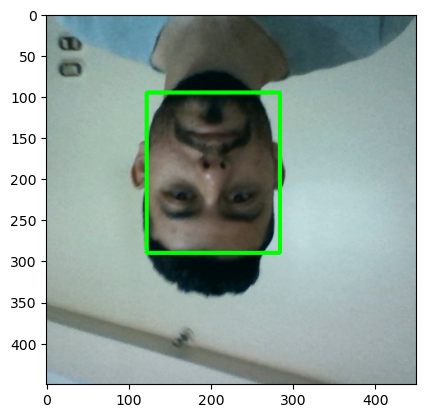

In [53]:
# Apply it on an image
img = cv2.imread('Train/Images/6257bd93-d17c-11ed-bcfa-8c16450c3b43.jpg')
with open('Train/Labels/6257bd93-d17c-11ed-bcfa-8c16450c3b43.json','r') as f:
    label = json.load(f)

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

# Normalize it
coords = list(np.divide(coords,[640,480,640,480]))

# Get augmented img
augmented = augmentor(image = img,bboxes = [coords],class_labels = ['face'])

# Create a rectangle
cv2.rectangle(augmented['image'],
              # Unnormalize coords
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype('int')),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype('int')),
              (0,255,0),3)
# Show the image
plt.imshow(cv2.cvtColor(augmented['image'],cv2.COLOR_BGR2RGB))
plt.show()

In [89]:
# Prepare augmented dirs
os.makedirs('aug_data')
for dire in folders:
    os.makedirs(os.path.join('aug_data',dire,'Images'))
    os.makedirs(os.path.join('aug_data',dire,'Labels'))

# Apply the pipeline on the whole data
for folder in folders:
    for img in os.listdir(folder+'/Images'):
        image = cv2.imread(folder+'/Images/'+img)
        label_path = os.path.join(folder,'Labels',img.split('.')[0]+'.json')
        
        # Check label
        coords = [0,0,0.00001,0.00001]
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label = json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[640,480,640,480]))
        try:
            for i in range(50):
                augmented = augmentor(image = image,bboxes = [coords],class_labels = ['face'])
                cv2.imwrite('aug_data/'+folder+'/Images/'+img.split('.')[0]+'.'+str(i)+'.jpg',augmented['image'])
                annot = {}
                annot['image'] = img
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annot['bbox'] = [0,0,0,0]
                        annot['class'] = 0
                    else:
                        annot['bbox'] = augmented['bboxes'][0]
                        annot['class'] = 1
                else:
                    annot['bbox'] = [0,0,0,0]
                    annot['class'] = 0
                with open('aug_data/'+folder+'/Labels/'+img.split('.')[0]+'.'+str(i)+'.json', 'w') as f:
                    json.dump(annot,f)
        except Exception as e:
            print(e)

### Data Preparation

In [5]:
# Splitting the data for training and validation and testing

# Training set
train = tf.data.Dataset.list_files('aug_data/Train/Images/*.jpg',shuffle=False)
train = train.map(load_img)
train = train.map(lambda img: tf.image.resize(img,(120,120)))
train = train.map(lambda img: img / 255)

# Validation set
val = tf.data.Dataset.list_files('aug_data/Val/Images/*.jpg',shuffle=False)
val = val.map(load_img)
val = val.map(lambda img: tf.image.resize(img,(120,120)))
val = val.map(lambda img: img/255)

# Testing set
test = tf.data.Dataset.list_files('aug_data/Test/Images/*.jpg',shuffle=False)
test = test.map(load_img)
test = test.map(lambda img: tf.image.resize(img,(120,120)))
test = test.map(lambda img: img / 255)

# Preparing the labels
def load_labels(path):
    with open(path.numpy(),'r',encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']],label['bbox']

# Training labels
train_labels = tf.data.Dataset.list_files('aug_data/Train/Labels/*.json',shuffle=False)
train_labels = train_labels.map(lambda label: tf.py_function(load_labels,[label],[tf.uint8,tf.float16]))

# Validation labels
val_labels = tf.data.Dataset.list_files('aug_data/Val/Labels/*.json',shuffle=False)
val_labels = val_labels.map(lambda label: tf.py_function(load_labels,[label],[tf.uint8,tf.float16]))

# Testing labels
test_labels = tf.data.Dataset.list_files('aug_data/Test/Labels/*.json',shuffle = False)
test_labels = test_labels.map(lambda label: tf.py_function(load_labels,[label],[tf.uint8,tf.float16]))

# Merging the images and the labels

# Training 
train = tf.data.Dataset.zip((train,train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

# Validation
val = tf.data.Dataset.zip((val,val_labels))
val = val.shuffle(600)
val = val.batch(8)
val = val.prefetch(4)

# Testing
test = tf.data.Dataset.zip((test,test_labels))
test = test.shuffle(500)
test = test.batch(8)
test = test.prefetch(4)

### Building The DL Models

In [7]:
# VGG16
vgg_net = VGG16(include_top=False)

# The net summary
vgg_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
# Building the models
def facedet_models():
    # The backbone model
    input_layer = Input(shape = (120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    
    # The classification model
    cls = GlobalMaxPooling2D()(vgg)
    cls = Dense(2048,activation='relu')(cls)
    cls = Dense(1,activation='sigmoid')(cls)
    
    # The regression model
    reg = GlobalMaxPooling2D()(vgg)
    reg = Dense(2048,activation='relu')(reg)
    reg = Dense(4,activation='sigmoid')(reg)
    
    # The final model
    model = Model(inputs = input_layer,outputs = [cls,reg])
    return model

In [32]:
# The model summary
face_det = facedet_models()
face_det.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [17]:
# Define lr decay
# Reducing lr on each epoch by lr decay
# Trying to reduce the issue of overfitting
batches_per_epoch = len(train)
lr_decay = (1.0 / 0.75 - 1) / batches_per_epoch
print('Lr decay = {}'.format(lr_decay))

Lr decay = 0.0006349206349206348


In [30]:
# Define the optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay = lr_decay)

# Define the localization loss
def loc_loss(y_actual,y_pred):
    # Get the lambda coord
    lambda_coord = tf.reduce_sum(tf.square(y_actual[:,:2] - y_pred[:,:2]))
    
    # Get the lambda size
    w_actual = y_actual[:,2] - y_actual[:,0]
    h_actual = y_actual[:,3] - y_actual[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]
    h_pred = y_pred[:,3] - y_pred[:,1]
    lambda_size = tf.reduce_sum(tf.square(w_actual - w_pred) + tf.square(h_actual - h_pred))
    
    # The result
    return lambda_coord + lambda_size
reg_loss = loc_loss

# Define the classification loss
class_loss = tf.keras.losses.BinaryCrossentropy()

In [36]:
# Create the Face Detector class
class FaceDetector(Model):
    # Initialization function
    def __init__(self,facedetector):
        super().__init__()
        self.model = facedetector
    
    # Compile function 
    def compile(self,opt,locloss,clasloss):
        super().compile()
        self.opt = opt
        self.lloss = locloss
        self.closs = clasloss
    
    # Training step
    def train_step(self,batch):
        x,y = batch
        
        # Apply training operations
        with tf.GradientTape() as tape:
            # Get prediction
            classes,coords = self.model(x,training = True)
            
            # Compute the loss
            class_loss = self.closs(y[0],classes)
            reg_loss = self.lloss(tf.cast(y[1],tf.float32),coords)
            total_loss = reg_loss + 0.5 * class_loss
            
            # Apply gradients
            grade = tape.gradient(total_loss,self.model.trainable_variables)
            
        # Get back prop
        self.opt.apply_gradients(zip(grade,self.model.trainable_variables))
        
        # The res
        return {'total_loss':total_loss,'class_loss':class_loss,'reg_loss':reg_loss}

    # Testing step
    def test_step(self,batch):
        # Get the x and y
        x,y = batch
        
        # Get pred
        classes,coords = self.model(x,training = False)
        
        # Get the loss
        class_loss = self.closs(y[0],classes)
        reg_loss = self.lloss(tf.cast(y[1],tf.float32),coords)
        total_loss = reg_loss + 0.5 * class_loss
        
        # The res
        return {'total_loss':total_loss,'class_loss':class_loss,'reg_loss':reg_loss}
    
    # To call .predict func
    def call(self,x):
        return self.model(x)

In [37]:
# Compiling the model
model = FaceDetector(face_det)
model.compile(optimizer,reg_loss,class_loss)

In [38]:
# Fitting the model
hist = model.fit(train,epochs = 20,validation_data=val)

Epoch 1/20
525/525 [==============================] - 1373s 3s/step - total_loss: 0.1782 - class_loss: 0.0459 - reg_loss: 0.1553 - val_total_loss: 0.0140 - val_class_loss: 2.2002e-04 - val_reg_loss: 0.0139
Epoch 2/20
525/525 [==============================] - 1377s 3s/step - total_loss: 0.0238 - class_loss: 3.3844e-04 - reg_loss: 0.0237 - val_total_loss: 0.0292 - val_class_loss: 1.0985e-04 - val_reg_loss: 0.0291
Epoch 3/20
525/525 [==============================] - 1420s 3s/step - total_loss: 0.0160 - class_loss: 1.1654e-04 - reg_loss: 0.0159 - val_total_loss: 0.0389 - val_class_loss: 2.9316e-05 - val_reg_loss: 0.0389
Epoch 4/20
525/525 [==============================] - 1489s 3s/step - total_loss: 0.0121 - class_loss: 7.2980e-05 - reg_loss: 0.0120 - val_total_loss: 0.0024 - val_class_loss: 1.4296e-05 - val_reg_loss: 0.0024
Epoch 5/20
525/525 [==============================] - 1401s 3s/step - total_loss: 0.0097 - class_loss: 4.5691e-05 - reg_loss: 0.0097 - val_total_loss: 0.0195 - val_

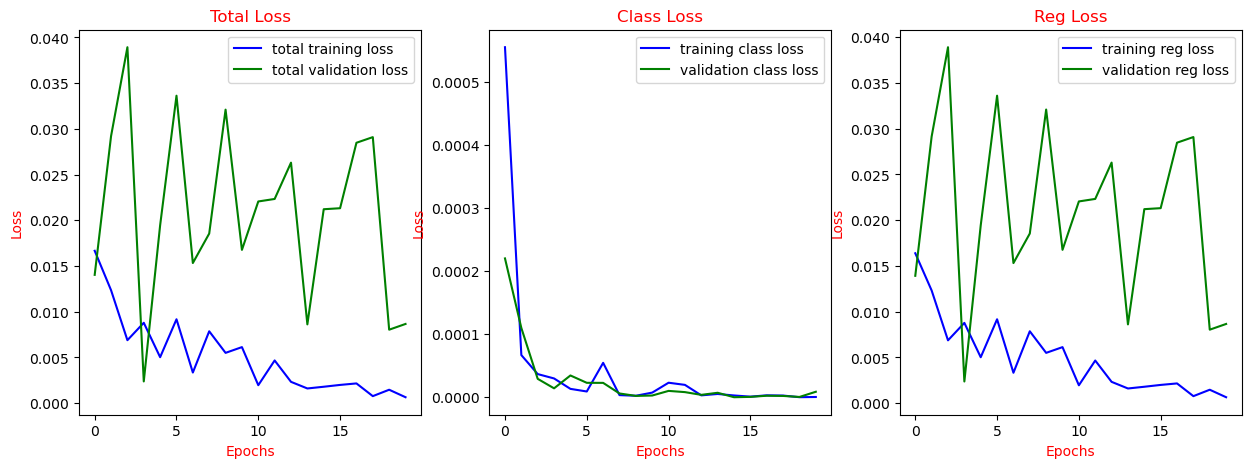

In [117]:
# The model performance

# The total loss
fig,ax = plt.subplots(ncols=3,figsize = (15,5))
ax[0].plot(hist.history['total_loss'],color = 'blue',label = 'total training loss')
ax[0].plot(hist.history['val_total_loss'],color = 'green',label = 'total validation loss')
ax[0].set_xlabel('Epochs',c = 'red')
ax[0].set_ylabel('Loss', c ='red')
ax[0].set_title('Total Loss',c = 'red')
ax[0].legend()

# Class loss
ax[1].plot(hist.history['class_loss'],color = 'blue',label = 'training class loss')
ax[1].plot(hist.history['val_class_loss'],color = 'green',label = 'validation class loss')
ax[1].set_xlabel('Epochs',c = 'red')
ax[1].set_ylabel('Loss',c = 'red')
ax[1].set_title('Class Loss',c = 'red')
ax[1].legend()

# Localization loss
ax[2].plot(hist.history['reg_loss'],color = 'blue',label = 'training reg loss')
ax[2].plot(hist.history['val_reg_loss'],color = 'green',label = 'validation reg loss')
ax[2].set_xlabel('Epochs',c = 'red')
ax[2].set_ylabel('Loss',c = 'red')
ax[2].set_title('Reg Loss',c = 'red')
ax[2].legend()

# Show the res
plt.show()

In [72]:
# Saving the model
face_det.save('FaceTrackerModel.h5')

### Real Time Face Tracking

In [80]:
# Loading the model
model = load_model('FaceTrackerModel.h5')

In [81]:
# The summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [116]:
# Capturing the video
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[50:500,50:500,:]
    
    # Convert frame to RGB
    rgb_img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    # Resizing the img
    rgb_img = tf.image.resize(rgb_img,(120,120))
    
    # Scale the images
    rgb_img = rgb_img / 255
    
    # Expand dim 
    rgb_img = np.expand_dims(rgb_img,0)
    
    # Get pred
    pred = model.predict(rgb_img)
    
    # Coords
    coords = pred[1][0]
    
    # Check pred
    if pred[0] > 0.5:
        # Main rect
        cv2.rectangle(frame,tuple(np.multiply(coords[:2],[450,450]).astype('int')),
                      tuple(np.multiply(coords[2:],[450,450]).astype('int')),
                      (250,0,0),2)
        
        # Text rect
        cv2.rectangle(frame,tuple(np.add(np.multiply(coords[:2],[450,450]).astype('int'),[0,-30])),
                      tuple(np.add(np.multiply(coords[:2],[450,450]).astype('int'),[80,0])),
                      (250,0,0),-1)
        
        # The text
        cv2.putText(frame,'face',tuple(np.add(np.multiply(coords[:2],[450,450]).astype('int'),[0,-5])),cv2.FONT_HERSHEY_SIMPLEX,
                   1,(255,255,255),1,cv2.LINE_AA)
        
        # Show the image
        cv2.imshow('Face Tracker',frame)
        
        # Check key
        if cv2.waitKey(1) & 0XFF == ord('q'):
            break

# Releasing the capture
cap.release()

# Destroying the window
cv2.destroyAllWindows()

1/1 [==============================] - 0s 126ms/step
